In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
import sklearn.mixture as sm

import myutils
from pyia import GaiaData

In [2]:
plt.style.use('notebook')

In [3]:
R = np.load('../data/jhelum_rotmat_init.npy')

In [4]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [5]:
t = Table(fits.getdata('../data/jhelum_des.fits'))

In [6]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [7]:
iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [8]:
# distance modulus
distance_app = 12.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['DECam_g']-iso['DECam_i'] + 0.05
i_g = iso['DECam_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.55*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>19)
poly_main = poly[ind]

In [9]:
wangle = 180*u.deg

In [10]:
def jhelum_dist(phi1, d0=12.8, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p1-p2)
    return (m*phi1.wrap_at(wangle).value + d1) * u.kpc

In [11]:
d0 = 12.8

In [12]:
cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [13]:
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (cj.phi2<-3*u.deg) & (cj.phi2>-4*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)

points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

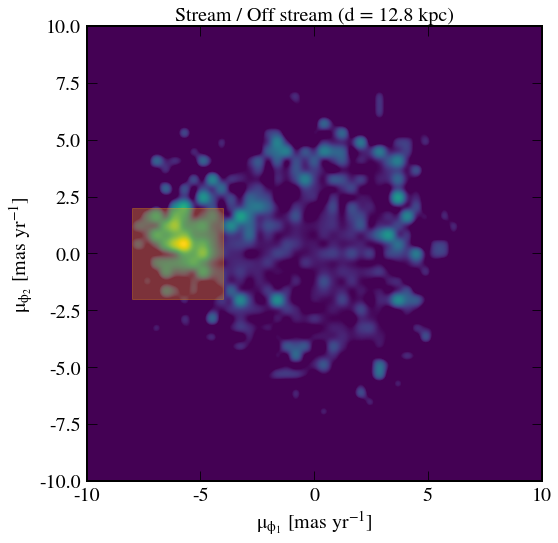

In [14]:
bx = np.linspace(-10,10,50)
Hon, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[phi2_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

Hoff, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

Hratio = np.zeros_like(Hon)
Hratio[Hoff>0] = Hon[Hoff>0] / Hoff[Hoff>0]
Hratio[Hratio==0] = 0.1

plt.imshow(Hratio.T, origin='lower', extent=[-10,10,-10,10], norm=mpl.colors.LogNorm(), vmin=1,
          interpolation='gaussian')

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Stream / Off stream (d = {:.1f} kpc)'.format(d0), fontsize='medium')

plt.tight_layout()

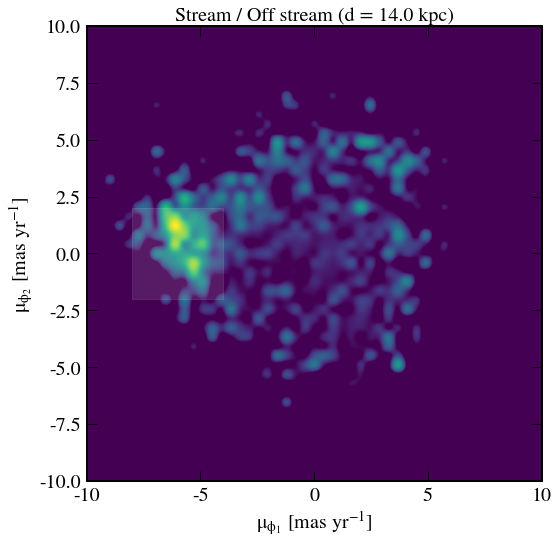

In [15]:
for d0 in np.arange(12.6,14.1,0.2):
    cj = c.transform_to(Jhelum)
    cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

    # Correct for reflex motion
    v_sun = coord.Galactocentric.galcen_v_sun
    observed = cj_dist.transform_to(coord.Galactic)
    rep = observed.cartesian.without_differentials()
    rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
    cj = coord.Galactic(rep).transform_to(Jhelum)
    
    # check proper motion space
    bx = np.linspace(-10,10,50)
    Hon, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
             cj.pm_phi2[phi2_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

    Hoff, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
             cj.pm_phi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

    Hratio = np.zeros_like(Hon)
    Hratio[Hoff>0] = Hon[Hoff>0] / Hoff[Hoff>0]
    Hratio[Hratio==0] = 0.1

    plt.close()
    plt.figure(figsize=(8,8))
    plt.imshow(Hratio.T, origin='lower', extent=[-10,10,-10,10], norm=mpl.colors.LogNorm(), vmin=1,
              interpolation='gaussian')

    rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
    rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
    rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
    pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='w', alpha=0.1)
    plt.gca().add_artist(pr)

    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
    plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
    plt.title('Stream / Off stream (d = {:.1f} kpc)'.format(d0), fontsize='medium')

    plt.tight_layout()
    plt.savefig('../plots/jhelum_pm_dist.{:.1f}.png'.format(d0), dpi=200)

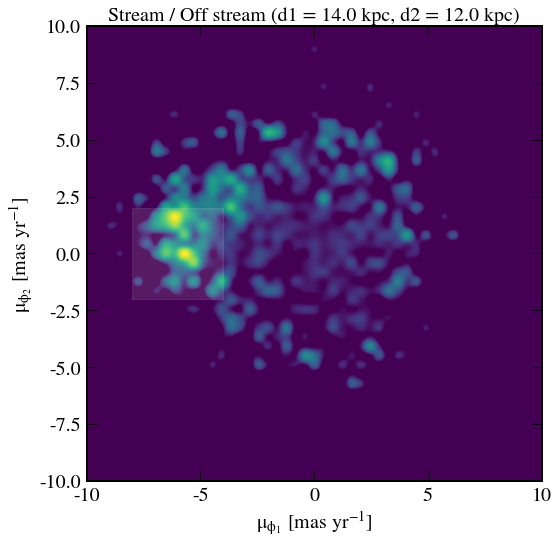

In [16]:
for d1,d2 in [[12,14],[12.5,13.5],[13.5,12.5],[14,12]]:
    cj = c.transform_to(Jhelum)
    cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d1=d1, d2=d2),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

    # Correct for reflex motion
    v_sun = coord.Galactocentric.galcen_v_sun
    observed = cj_dist.transform_to(coord.Galactic)
    rep = observed.cartesian.without_differentials()
    rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
    cj = coord.Galactic(rep).transform_to(Jhelum)
    
    # check proper motion space
    bx = np.linspace(-10,10,50)
    Hon, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
             cj.pm_phi2[phi2_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

    Hoff, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
             cj.pm_phi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

    Hratio = np.zeros_like(Hon)
    Hratio[Hoff>0] = Hon[Hoff>0] / Hoff[Hoff>0]
    Hratio[Hratio==0] = 0.1

    plt.close()
    plt.figure(figsize=(8,8))
    plt.imshow(Hratio.T, origin='lower', extent=[-10,10,-10,10], norm=mpl.colors.LogNorm(), vmin=1,
              interpolation='gaussian')

    rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
    rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
    rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
    pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='w', alpha=0.1)
    plt.gca().add_artist(pr)

    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
    plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
    plt.title('Stream / Off stream (d1 = {:.1f} kpc, d2 = {:.1f} kpc)'.format(d1, d2), fontsize='medium')

    plt.tight_layout()
    plt.savefig('../plots/jhelum_pm_distgrad.{:.1f}.{:.1f}.png'.format(d1,d2), dpi=200)

In [17]:
# adopt 13kpc
d0 = 13

cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [18]:
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (cj.phi2<-3*u.deg) & (cj.phi2>-4*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)

points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

## Position in the Galaxy

In [19]:
cgal = cj_dist.transform_to(coord.Galactocentric)

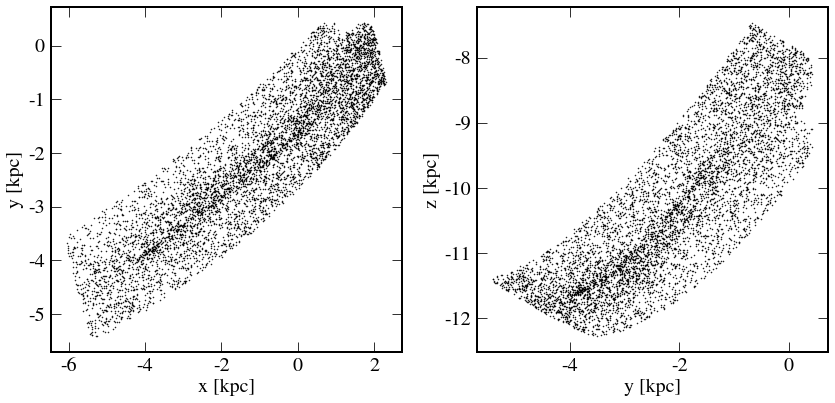

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

plt.sca(ax[0])
plt.plot(cgal.x[pm_mask & cmd_mask], cgal.y[pm_mask & cmd_mask], 'k.', ms=1)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')

plt.sca(ax[1])
plt.plot(cgal.y[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask], 'k.', ms=1)

plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')

plt.tight_layout()
# plt.savefig('../plots/jhelum_galactocentric.png', dpi=150)

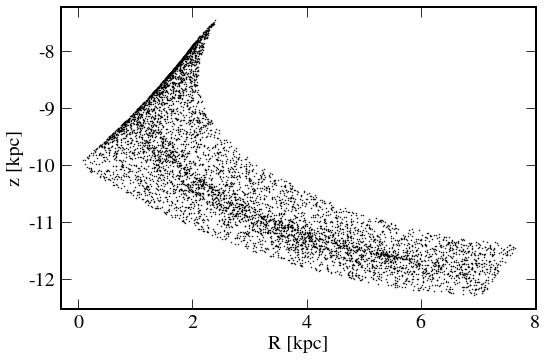

In [21]:
rgal = np.sqrt(cgal.x**2 + cgal.y**2)
plt.plot(rgal[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask], 'k.', ms=1)
plt.gca().set_aspect('equal')
# plt.quiver(Rin, zin, vcomb_pix[:,0], vcomb_pix[:,1], pivot='middle', 
#            headwidth=0, headlength=0, headaxislength=0, scale=0.02, scale_units='xy')
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')

plt.tight_layout()

In [22]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5,0,'Z (kpc)')

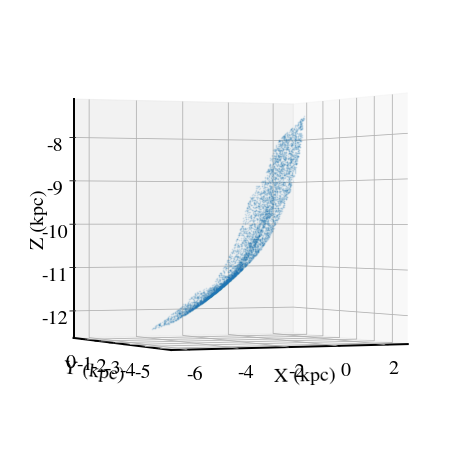

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

# ax.view_init(azim=120, elev=30)
ax.view_init(azim=245, elev=0)
ax.set_frame_on(False)

ax.scatter(cgal.x[pm_mask & cmd_mask], cgal.y[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask], 
           'o', depthshade=False, alpha=0.1, s=1)

ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')

In [24]:
tout = Table([cgal.x[pm_mask & cmd_mask], cgal.y[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask]], 
            names=('x', 'y', 'z'))

In [25]:
tout.write('../data/pos_galactocentric.fits', overwrite=True)

## Brutus inputs

In [26]:
tbrut = Table([g.l, g.b, g.parallax, g.parallax_error, g.phot_g_mean_mag, g.phot_g_mean_flux_over_error,
              g.phot_bp_mean_mag, g.phot_bp_mean_flux_over_error, g.phot_rp_mean_mag, g.phot_rp_mean_flux_over_error,
              g.g, g.g_error, g.r, g.r_error, g.i, g.i_error],
              names=('glon', 'glat', 'parallax', 'parallax_error', 'Gaia_G_DR2Rev', 'Gaia_G_DR2Rev_sig',
                     'Gaia_BP_DR2Rev', 'Gaia_BP_DR2Rev_sig', 'Gaia_RP_DR2Rev', 'Gaia_RP_DR2Rev_sig', 'DECam_g',
                    'DECam_g_sig', 'DECam_r', 'DECam_r_sig', 'DECam_i', 'DECam_i_sig'))

In [27]:
tbrut[pm_mask & cmd_mask].write('../data/jhelum_brutus_input.fits', overwrite=True)

In [28]:
tbrut_in = Table.read('../data/jhelum_brutus_input.fits')

In [29]:
len(tbrut_in)*8/3600

14.275555555555556

In [84]:
import h5py
from scipy.special import logsumexp

In [51]:
def draw_sav(scales, avs, covs_sa, ndraws=500, avlim=(0., 6.), rstate=None):
    """
    Generate random draws from the joint scale and Av posterior for a
    given object.
    Parameters
    ----------
    scales : `~numpy.ndarray` of shape `(Nsamps)`
        An array of scale factors derived between the model and the data.
    avs : `~numpy.ndarray` of shape `(Nsamps)`
        An array of reddenings derived between the model and the data.
    covs_sa : `~numpy.ndarray` of shape `(Nsamps, 2, 2)`
        An array of covariance matrices corresponding to `scales` and `avs`.
    ndraws : int, optional
        The number of desired random draws. Default is `500`.
    avlim : 2-tuple, optional
        The Av limits used to truncate results. Default is `(0., 6.)`.
    rstate : `~numpy.random.RandomState`, optional
        `~numpy.random.RandomState` instance.
    """

    if rstate is None:
        rstate = np.random

    # Generate realizations for each (scale, av, cov_sa) set.
    nsamps = len(scales)
    sdraws, adraws = np.zeros((nsamps, ndraws)), np.zeros((nsamps, ndraws))
    for i, (s, a, c) in enumerate(zip(scales, avs, covs_sa)):
        s_temp, a_temp = [], []
        # Loop is just in case a significant chunk of the distribution
        # falls outside of the bounds.
        while len(s_temp) < ndraws:
            s_mc, a_mc = rstate.multivariate_normal(np.array([s, a]), c,
                                                    size=ndraws*4).T
            inbounds = ((s_mc >= 0.) & (a_mc >= avlim[0]) &
                        (a_mc <= avlim[1]))  # flag out-of-bounds draws
            s_mc, a_mc = s_mc[inbounds], a_mc[inbounds]
            s_temp, a_temp = np.append(s_temp, s_mc), np.append(a_temp, a_mc)
        sdraws[i], adraws[i] = s_temp[:ndraws], a_temp[:ndraws]

    return sdraws, adraws

In [81]:
def parallax_lnprior(parallaxes, p_meas, p_err):
    """
    Apply parallax prior using a measured parallax.
    Parameters
    ----------
    parallaxes : `~numpy.ndarray` of shape (N)
        Parallaxes.
    p_meas : float, optional
        Measured parallax. Default is `0.`.
    p_std : float, optional
        Measured parallax error. Default is `1e10`.
    Returns
    -------
    lnprior : `~numpy.ndarray` of shape (Ngrid)
        The corresponding ln(prior).
    """

    if np.isfinite(p_meas) and np.isfinite(p_err):
        # Compute log-prior.
        chi2 = (parallaxes - p_meas)**2 / p_err**2  # chi2
        lnorm = np.log(2. * np.pi * p_err**2)  # normalization
        lnprior = -0.5 * (chi2 + lnorm)
    else:
        # If no measurement, assume a uniform prior everywhere.
        lnprior = np.zeros_like(parallaxes) - np.log(len(parallaxes))

    return lnprior

def logn_disk(R, Z, R_solar=8., Z_solar=0.025, R_scale=2.15, Z_scale=0.245):
    """
    Log-number density of stars in the disk component of the galaxy.
    Parameters
    ----------
    R : `~numpy.ndarray` of shape (N)
        The distance from the center of the galaxy.
    Z : `~numpy.ndarray` of shape (N)
        The height above the galactic midplane.
    R_solar : float, optional
        The solar distance from the center of the galaxy in kpc.
        Default is `8.`.
    Z_solar : float, optional
        The solar height above the galactic midplane in kpc.
        Default is `0.025`.
    R_scale : float, optional
        The scale radius of the disk in kpc. Default is `2.15`.
    Z_scale : float, optional
        The scale height of the disk in kpc. Default is `0.245`.
    Returns
    -------
    logn : `~numpy.ndarray` of shape (N)
        The corresponding normalized ln(number density).
    """

    rterm = (R - R_solar) / R_scale  # radius term
    zterm = (np.abs(Z) - np.abs(Z_solar)) / Z_scale  # height term

    return -(rterm + zterm)


def logn_halo(R, Z, R_solar=8., R_break=27.8, R_smooth=0.5, q_h=0.7,
              eta_inner=2.62, eta_outer=3.80):
    """
    Log-number density of stars in the halo component of the galaxy.
    Parameters
    ----------
    R : `~numpy.ndarray` of shape (N)
        The distance from the center of the galaxy.
    Z : `~numpy.ndarray` of shape (N)
        The height above the galactic midplane.
    R_solar : float, optional
        The solar distance from the center of the galaxy in kpc.
        Default is `8.`.
    R_break : float, optional
        The radius in kpc at which the density switches from the inner
        component to the outer component. Default is `27.8`.
    R_smooth : float, optional
        The smoothing radius in kpc used to avoid singularities
        around the galactic center. Default is `0.5`.
    q_h : float, optional
        The oblateness of the halo measured from `[0., 1.]`.
        Default is `0.7`.
    eta_inner : float, optional
        The (negative) power law index describing the number density
        in the inner portion of the halo (i.e. `R <= R_break`).
        Default is `2.62`.
    eta_outer : float, optional
        The (negative) power law index describing the number density in
        the outer portion of the halo (i.e. `R > R_break`).
        Default is `3.80`.
    Returns
    -------
    logn : `~numpy.ndarray` of shape (N)
        The corresponding normalized ln(number density).
    """

    # Initialize value.
    logn = np.zeros_like(R)

    # Compute effective radius.
    Reff = np.sqrt(R**2 + (Z / q_h)**2 + R_smooth**2)

    # Compute inner component.
    inner = Reff <= R_break
    logn[inner] = -eta_inner * np.log(Reff[inner] / R_solar)

    # Compute outer component
    offset = (eta_outer - eta_inner) * np.log(R_break / R_solar)
    logn[~inner] = -eta_outer * np.log(Reff[~inner] / R_solar) + offset

    return logn

def gal_lnprior(dists, c, R_solar=8., Z_solar=0.025,
                R_thin=2.15, Z_thin=0.245, R_thick=3.26, Z_thick=0.745,
                f_thick=0.13, Rb_halo=27.8, Rs_halo=0.5, q_halo=0.7,
                eta_halo_inner=2.62, eta_halo_outer=3.80, f_halo=0.003,
                return_components=False):
    """
    Log-prior in distance for a galactic model containing a thin disk,
    thick disk, and halo. Parameters taken from Green et al. (2014).
    Parameters
    ----------
    dists : `~numpy.ndarray` of shape (N)
        Distance from the observer in kpc.
    c : 2-tuple
        The `(l, b)` galaxy coordinates of the object.
    R_solar : float, optional
        The solar distance from the center of the galaxy in kpc.
        Default is `8.`.
    Z : `~numpy.ndarray` of shape (N)
        The height above the galactic midplane.
    R_solar : float, optional
        The solar distance from the center of the galaxy in kpc.
        Default is `8.`.
    Z_solar : float, optional
        The solar height above the galactic midplane in kpc.
        Default is `0.025`.
    R_thin : float, optional
        The scale radius of the thin disk in kpc. Default is `2.15`.
    Z_thin : float, optional
        The scale height of the thin disk in kpc. Default is `0.245`.
    R_thick : float, optional
        The scale radius of the thin disk in kpc. Default is `3.26`.
    Z_thick : float, optional
        The scale height of the thin disk in kpc. Default is `0.745`.
    f_thick : float, optional
        The fractional weight applied to the thick disk number density.
        Default is `0.13`.
    Rb_halo : float, optional
        The radius in kpc at which the density switches from the inner
        component to the outer component in the halo. Default is `27.8`.
    Rs_halo : float, optional
        The smoothing radius in kpc used to avoid singularities
        around the galactic center. Default is `0.5`.
    q_halo : float, optional
        The oblateness of the halo measured from `[0., 1.]`.
        Default is `0.7`.
    eta_halo_inner : float, optional
        The (negative) power law index describing the number density
        in the inner portion of the halo (i.e. `R <= R_break`).
        Default is `2.62`.
    eta_halo_outer : float, optional
        The (negative) power law index describing the number density in
        the outer portion of the halo (i.e. `R > R_break`).
        Default is `3.80`.
    f_halo : float, optional
        The fractional weight applied to the halo number density.
        Default is `0.003`.
    return_components : bool, optional
        Whether to also return the separate components. Default is `False`.
    Returns
    -------
    lnprior : `~numpy.ndarray` of shape (N)
        The corresponding normalized ln(prior).
    lnprior_thin : `~numpy.ndarray` of shape (N), optional
        The corresponding normalized ln(prior) from the thin disk.
    lnprior_thick : `~numpy.ndarray` of shape (N), optional
        The corresponding normalized ln(prior) from the thick disk.
    lnprior_halo : `~numpy.ndarray` of shape (N), optional
        The corresponding normalized ln(prior) from the halo.
    """

    # Compute volume factor.
    vol_factor = 2. * np.log(dists + 1e-300)  # dV = r**2 factor

    # Convert from observer-based coordinates to galactocentric cylindrical
    # coordinates.
    l, b = np.full_like(dists, c[0]), np.full_like(dists, c[1])
    coords = coord.SkyCoord(l=l*u.deg, b=b*u.deg, distance=dists*u.kpc,
                      frame='galactic')
    coords_cyl = coords.galactocentric.cartesian.represent_as(coord.CylindricalRepresentation)
    R, Z = coords_cyl.rho.value, coords_cyl.z.value  # radius and height

    # Get thin disk component.
    logp_thin = logn_disk(R, Z, R_solar=R_solar, Z_solar=Z_solar,
                          R_scale=R_thin, Z_scale=Z_thin)
    logp_thin += vol_factor

    # Get thick disk component.
    logp_thick = logn_disk(R, Z, R_solar=R_solar, Z_solar=Z_solar,
                           R_scale=R_thick, Z_scale=Z_thick)
    logp_thick += vol_factor + np.log(f_thick)

    # Get halo component.
    logp_halo = logn_halo(R, Z, R_solar=R_solar, R_break=Rb_halo,
                          R_smooth=Rs_halo, q_h=q_halo,
                          eta_inner=eta_halo_inner, eta_outer=eta_halo_outer)
    logp_halo += vol_factor + np.log(f_halo)

    # Compute log-probability.
    lnprior = logsumexp([logp_thin, logp_thick, logp_halo], axis=0)

    if not return_components:
        return lnprior
    else:
        return lnprior, logp_thin, logp_thick, logp_halo

In [33]:
f = h5py.File('../data/jhelum_brutus_mist_v4.1.h5')

In [41]:
s_mist = f['scales'][:]
av_mist = f['avs'][:]
cov_mist = f['cov_sa'][:]
idxs_mist = f['idxs'][:]
chi2_mist = f['best_chi2'][:]
levid_mist = f['log_evidence'][:]
nbands_mist = f['Nbands'][:]

In [113]:
index = 0

In [114]:
applied_parallax=True
plx = tbrut_in['parallax'][index]
plx_err = tbrut_in['parallax_error'][index]
c = (tbrut_in['glon'][index], tbrut_in['glat'][index])

lndistprior = gal_lnprior

np.random.seed(782)
rstate = np.random

idxs = idxs_mist[index]
avs = av_mist[index]
scales = s_mist[index]
covs_sa = cov_mist[index]

Nr = 500
avlim = (0., 6.)

In [115]:
# Add in parallax and Av realizations.
nsamps = len(idxs)
sdraws, adraws = draw_sav(scales, avs, covs_sa, ndraws=Nr, avlim=avlim,
                          rstate=rstate)
pdraws = np.sqrt(sdraws)
ddraws = 1. / pdraws

# Re-apply distance and parallax priors to realizations.
lnp_draws = lndistprior(ddraws, c)
if applied_parallax:
    lnp_draws += parallax_lnprior(pdraws, plx, plx_err)

# Resample draws.
lnp = logsumexp(lnp_draws, axis=1)
pwt = np.exp(lnp_draws - lnp[:, None])
pwt /= pwt.sum(axis=1)[:, None]
ridx = [rstate.choice(Nr, p=pwt[i]) for i in range(nsamps)]
pdraws = pdraws[np.arange(nsamps), ridx]
ddraws = ddraws[np.arange(nsamps), ridx]
adraws = adraws[np.arange(nsamps), ridx]

In [116]:
p = np.percentile(pdraws, [16,50,84])
parallax_err_dn = p[1] - p[0]
parallax_err_up = p[2] - p[1]
parallax = p[1]
print(r'${{{0:.3}}}_{{-{1:.3}}}^{{+{2:.3}}}$'.format(parallax, parallax_err_dn, parallax_err_up))

${0.11}_{-0.0276}^{+0.0208}$


In [117]:
p = np.percentile(ddraws, [16,50,84])
dist_err_dn = p[1] - p[0]
dist_err_up = p[2] - p[1]
dist = p[1]
print(r'${{{0:.3}}}_{{-{1:.3}}}^{{+{2:.3}}}$'.format(dist, dist_err_dn, dist_err_up))

${9.12}_{-1.46}^{+3.07}$


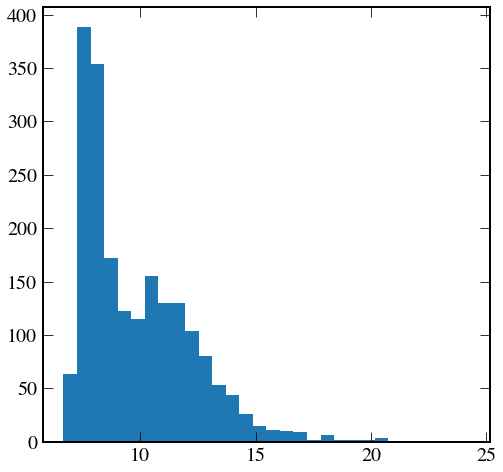

In [118]:
plt.hist(ddraws, bins=30);

In [119]:
Nstar = len(tbrut_in)
parallax = np.empty(Nstar)
parallax_edn = np.empty(Nstar)
parallax_eup = np.empty(Nstar)
distance = np.empty(Nstar)
distance_edn = np.empty(Nstar)
distance_eup = np.empty(Nstar)

for index in range(Nstar):
    applied_parallax=True
    plx = tbrut_in['parallax'][index]
    plx_err = tbrut_in['parallax_error'][index]
    c = (tbrut_in['glon'][index], tbrut_in['glat'][index])

    idxs = idxs_mist[index]
    avs = av_mist[index]
    scales = s_mist[index]
    covs_sa = cov_mist[index]
    
    # Add in parallax and Av realizations.
    nsamps = len(idxs)
    sdraws, adraws = draw_sav(scales, avs, covs_sa, ndraws=Nr, avlim=avlim,
                              rstate=rstate)
    pdraws = np.sqrt(sdraws)
    ddraws = 1. / pdraws

    # Re-apply distance and parallax priors to realizations.
    lnp_draws = lndistprior(ddraws, c)
    if applied_parallax:
        lnp_draws += parallax_lnprior(pdraws, plx, plx_err)

    # Resample draws.
    lnp = logsumexp(lnp_draws, axis=1)
    pwt = np.exp(lnp_draws - lnp[:, None])
    pwt /= pwt.sum(axis=1)[:, None]
    ridx = [rstate.choice(Nr, p=pwt[i]) for i in range(nsamps)]
    pdraws = pdraws[np.arange(nsamps), ridx]
    ddraws = ddraws[np.arange(nsamps), ridx]
    adraws = adraws[np.arange(nsamps), ridx]
    
    # store parallax
    p = np.percentile(pdraws, [16,50,84])
    parallax_edn[index] = p[1] - p[0]
    parallax_eup[index] = p[2] - p[1]
    parallax[index] = p[1]
    
    # store distance
    p = np.percentile(ddraws, [16,50,84])
    distance_edn[index] = p[1] - p[0]
    distance_eup[index] = p[2] - p[1]
    distance[index] = p[1]

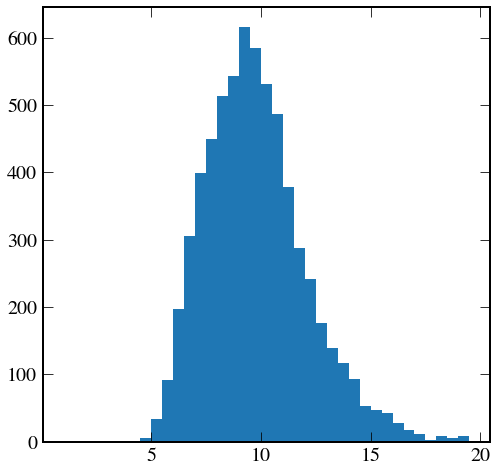

In [121]:
plt.hist(distance, bins=np.arange(1,20,0.5));

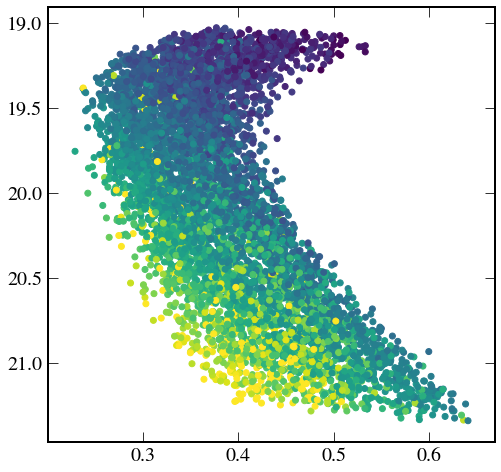

In [124]:
plt.scatter(tbrut_in['DECam_g']-tbrut_in['DECam_i'],tbrut_in['DECam_g'], c=distance, vmin=5,vmax=15)

plt.gca().invert_yaxis()

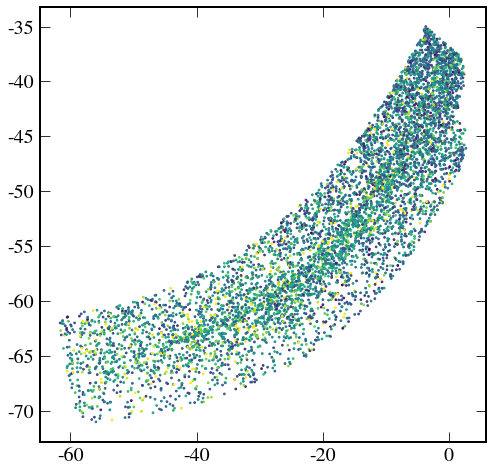

In [129]:
plt.scatter(coord.Angle(tbrut_in['glon']).wrap_at(wangle), tbrut_in['glat'], c=distance, vmin=5,vmax=15, s=3)

In [131]:
tbrut_out = Table([distance, distance_edn, distance_eup, parallax, parallax_edn, parallax_eup],
                 names=('distance', 'distance_edn', 'distance_eup', 'parallax', 'parallax_edn', 'parallax_eup'))

In [132]:
tbrut_out.write('../data/brutus_distances.fits', overwrite=True)